In [1]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# synthetic data generation
num_samples = 1000
x1 = np.random.uniform(-5, 5, num_samples)
x2 = np.random.uniform(-5, 5, num_samples)
x3 = np.random.uniform(-5, 5, num_samples)

# non-linear equation for target value y
y = np.sin(x1) * np.cos(x2) + np.log(1 + x3 ** 2)

# stack the inputs values as a matrix (num_samples, 3)
X_np = np.vstack((x1, x2, x3)).T
y_np = y.reshape(-1, 1)

# convert to TensorFlow tensors
X = tf.convert_to_tensor(X_np, dtype=tf.float32)
y_true = tf.convert_to_tensor(y_np, dtype=tf.float32)

print("Input Shape:", X.shape)
print("Target Shape:", y_true.shape)

Input Shape: (1000, 3)
Target Shape: (1000, 1)


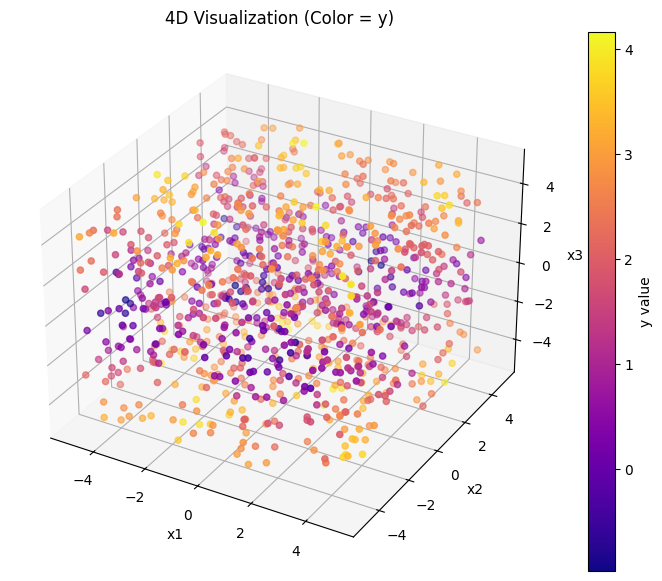

In [3]:
# 3D scatter plot to visualize the input features (x1, x2, x3)
# color of each point represents the corresponding target y value
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x1, x2, x3, c=y, cmap='plasma')

plt.colorbar(sc, label='y value')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.title('4D Visualization (Color = y)')
plt.show()

In [4]:
# ReLU activation function for hidden layers
def relu(z):
    return tf.maximum(0.0, z)

# derivative of ReLU for use in backpropagation
def relu_derivative(z):
    return tf.cast(z > 0, dtype=tf.float32)

# identity activation function for regression output (no activation)
def identity(z):
    return z

# derivative of identity function, required for backpropagation
def identity_derivative(z):
    return tf.ones_like(z)

# mean squared error loss function
def mse_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [5]:
# define neural network architecture sizes
input_size = 3        # number of input features (x1, x2, x3)
hidden1_size = 8      # first hidden layer neurons
hidden2_size = 6      # second hidden layer neurons
output_size = 1       # single output (regression)

# initialize weights with small random values (Normal distribution)
W1 = tf.Variable(tf.random.normal((input_size, hidden1_size), stddev=0.01))
W2 = tf.Variable(tf.random.normal((hidden1_size, hidden2_size), stddev=0.01))
W3 = tf.Variable(tf.random.normal((hidden2_size, output_size), stddev=0.01))

# initialize biases to zero vectors
b1 = tf.Variable(tf.zeros((1, hidden1_size)))
b2 = tf.Variable(tf.zeros((1, hidden2_size)))
b3 = tf.Variable(tf.zeros((1, output_size)))

In [6]:
def forward_pass(X):
    """
    Perform forward propagation through the network.
    Arguments: X -- input features (batch_size, input_size)
    Returns: A3 -- final output (batch_size, output_size), cache -- intermediate results for backpropagation
    """

    # layer 1: Linear transformation + ReLU activation
    Z1 = tf.einsum('ij,jk->ik', X, W1) + b1  # matrix multiply + bias
    A1 = relu(Z1)                            # non-linear activation

    # layer 2: Linear transformation + ReLU activation
    Z2 = tf.einsum('ij,jk->ik', A1, W2) + b2
    A2 = relu(Z2)

    # output layer: Linear transformation + identity activation (regression)
    Z3 = tf.einsum('ij,jk->ik', A2, W3) + b3
    A3 = identity(Z3)

    # cache values for backpropagation
    cache = (X, Z1, A1, Z2, A2, Z3, A3)

    return A3, cache

In [7]:
def backward_pass(y_pred, y_true, cache):
    """
    Perform manual backpropagation and compute gradients for all parameters.

    Arguments:
    y_pred -- predicted output from forward pass
    y_true -- actual target values
    cache -- cached values from forward pass

    Returns: Gradients for W1, b1, W2, b2, W3, b3
    """
    X, Z1, A1, Z2, A2, Z3, A3 = cache
    m = tf.cast(tf.shape(y_true)[0], tf.float32)

    # compute gradient of loss
    dA3 = (2.0 / m) * (A3 - y_true)  # derivative of MSE loss

    # output layer gradients (Identity activation)
    dZ3 = dA3 * identity_derivative(Z3)
    dW3 = tf.einsum('ij,ik->jk', A2, dZ3)
    db3 = tf.reduce_sum(dZ3, axis=0, keepdims=True)

    # backpropagate to layer 2 (ReLU activation)
    dA2 = tf.einsum('ij,jk->ik', dZ3, tf.transpose(W3))
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = tf.einsum('ij,ik->jk', A1, dZ2)
    db2 = tf.reduce_sum(dZ2, axis=0, keepdims=True)

    # backpropagate to layer 1 (ReLU activation)
    dA1 = tf.einsum('ij,jk->ik', dZ2, tf.transpose(W2))
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = tf.einsum('ij,ik->jk', X, dZ1)
    db1 = tf.reduce_sum(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

In [8]:
epochs = 5000
learning_rate = 0.01
losses = []

for epoch in range(epochs):
    y_pred, cache = forward_pass(X) # forward pass to compute predictions and cache activations

    loss = mse_loss(y_pred, y_true) # Compute loss
    losses.append(loss.numpy())

    dW1, db1, dW2, db2, dW3, db3 = backward_pass(y_pred, y_true, cache) # backward pass to compute gradients

    # update weights and biases manually using gradient descent
    W1.assign_sub(learning_rate * dW1)
    b1.assign_sub(learning_rate * db1)

    W2.assign_sub(learning_rate * dW2)
    b2.assign_sub(learning_rate * db2)

    W3.assign_sub(learning_rate * dW3)
    b3.assign_sub(learning_rate * db3)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy():.6f}")

print(f"\nFinal Loss after {epochs} epochs: {losses[-1]:.6f}")

Epoch 0: Loss = 4.638873
Epoch 500: Loss = 1.268244
Epoch 1000: Loss = 1.267959
Epoch 1500: Loss = 1.265530
Epoch 2000: Loss = 1.056653
Epoch 2500: Loss = 0.281204
Epoch 3000: Loss = 0.264332
Epoch 3500: Loss = 0.260632
Epoch 4000: Loss = 0.259064
Epoch 4500: Loss = 0.258144

Final Loss after 5000 epochs: 0.257277


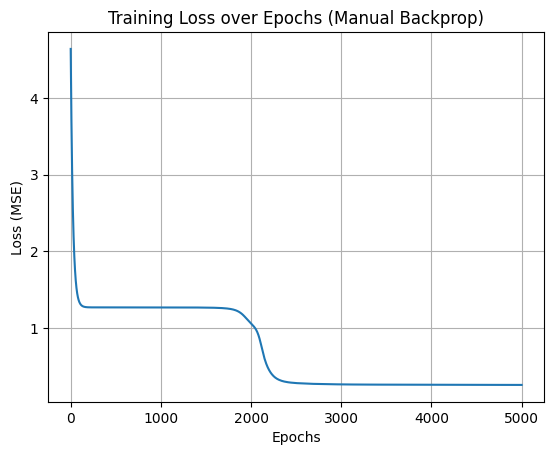

In [9]:
# plot the training loss curve
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss over Epochs (Manual Backprop)')
plt.grid(True)
plt.show()

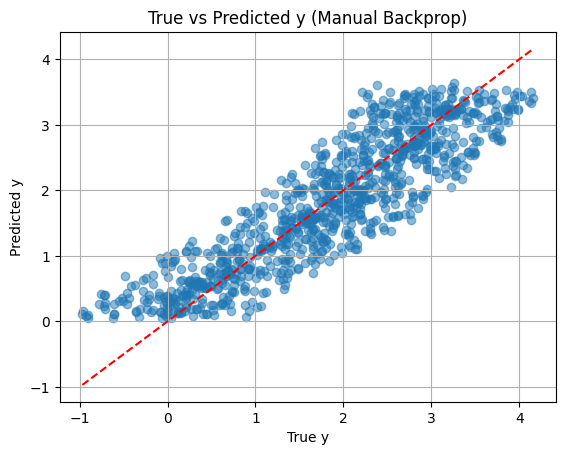

In [10]:
# perform a final forward pass to get predictions
y_final_pred, _ = forward_pass(X)

# Scatter plot: True vs Predicted y values
plt.scatter(y_np, y_final_pred.numpy(), alpha=0.5)
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.title('True vs Predicted y (Manual Backprop)')
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], 'r--')
plt.grid(True)
plt.show()